In [1]:
!pip install --user face-recognition

In [2]:
! pip install tensorflow --upgrade

Defaulting to user installation because normal site-packages is not writeable
  Using cached tensorflow-2.5.0-cp37-cp37m-manylinux2010_x86_64.whl (454.3 MB)
  Using cached idna-2.8-py2.py3-none-any.whl (58 kB)
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [27]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torch.utils.data import sampler
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision.models as models
import torchvision.transforms as T
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from tqdm import tqdm_notebook, tnrange, tqdm
import xml.etree.ElementTree as ET
import copy
import face_recognition
import tensorflow as tf
from tensorflow import keras
#from tensorflow.keras import layers
from PIL import Image

In [28]:
dtype = torch.float32 

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


In [29]:
widths = []
heights = []
for annotation_file in sorted(os.listdir('./input/Face_Mask_Dataset/annotations')):
    annotation_path = os.path.join('./input/Face_Mask_Dataset/annotations', annotation_file)

    # https://www.kaggle.com/bitthal/understanding-input-data-and-loading-with-pytorch
    tree = tree = ET.parse(annotation_path)
    root = tree.getroot()
    objects = root.findall('object')
    for obj in objects:
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        widths.append(xmax - xmin)
        heights.append(ymax - ymin)
        
np.mean(widths), np.mean(heights)

(31.149066797642437, 35.0049115913556)

In [30]:
total_num_images = 4072
train_indices = (0, int(0.80 * total_num_images))
val_indices = (int(0.80 * total_num_images), int(0.9 * total_num_images))
test_indices =  (int(0.9 * total_num_images), total_num_images)
train_indices, val_indices, test_indices

((0, 3257), (3257, 3664), (3664, 4072))

In [34]:
class FaceMaskDataset(Dataset):
    def __init__(self, img_dir, annotations_dir, indices):
        self.img_dir = img_dir
        self.label_dict  = {'with_mask': 0, 'without_mask': 1, 'mask_weared_incorrect': 2}
        self.faces = []
        
        for annotation_file in sorted(os.listdir(annotations_dir)):
            annotation_path = os.path.join(annotations_dir, annotation_file)

            # https://www.kaggle.com/bitthal/understanding-input-data-and-loading-with-pytorch
            tree = tree = ET.parse(annotation_path)
            root = tree.getroot()
            filename = root.find('filename').text
            objects = root.findall('object')
            for obj in objects:
                label = self.label_dict[obj.find('name').text]
                bndbox = obj.find('bndbox')
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)
                bbox = (xmin, ymin, xmax, ymax)
                self.faces.append((filename, bbox, label))
        
        self.faces = self.faces[indices[0]:indices[1]]
                        
    def __len__(self):
        return len(self.faces)

    def __getitem__(self, idx):
        image_path = os.path.join(self.img_dir, self.faces[idx][0])
        img = Image.open(image_path).convert('RGB')
        cropped_img = img.crop(self.faces[idx][1])
        # Normalize stats from ImageNet
        compose = T.Compose([
            T.Resize((35, 35)),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
        ])
        
        return compose(cropped_img), self.faces[idx][2], idx

In [35]:

train_face_mask_dataset = FaceMaskDataset(img_dir='./input/Face_Mask_Dataset/images', annotations_dir='./input/Face_Mask_Dataset/annotations', indices=train_indices)
train_face_mask_dataloader = DataLoader(train_face_mask_dataset, batch_size=128, shuffle=True)

valid_face_mask_dataset = FaceMaskDataset(img_dir='./input/Face_Mask_Dataset/images', annotations_dir='./input/Face_Mask_Dataset/annotations', indices=val_indices)
valid_face_mask_dataloader = DataLoader(valid_face_mask_dataset, batch_size=128)

test_face_mask_dataset = FaceMaskDataset(img_dir='./input/Face_Mask_Dataset/images', annotations_dir='./input/Face_Mask_Dataset/annotations', indices=test_indices)
test_face_mask_dataloader = DataLoader(test_face_mask_dataset, batch_size=128)

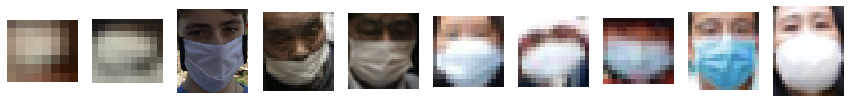

In [36]:
figs, axs = plt.subplots(1, 10, figsize=(15,15))

tmp_dataset = FaceMaskDataset(img_dir='./input/Face_Mask_Dataset/images', annotations_dir='./input/Face_Mask_Dataset/annotations', indices=test_indices)
count = 0
# Boiler plate code to display some of the images
for img, label, idx in DataLoader(tmp_dataset, batch_size=1):
    orig_image = Image.open(os.path.join(tmp_dataset.img_dir, tmp_dataset.faces[idx][0])).convert('RGB')
    cropped_img = orig_image.crop(tmp_dataset.faces[idx][1])
    axs[count].imshow(cropped_img)
    axs[count].axis('off')
    count += 1
    if count == 10:
        break

In [37]:
num_mask = 0
num_no_mask = 0
num_bad_mask = 0
for imgs, labels, _ in train_face_mask_dataloader:
    num_mask += (labels == 0).sum().item()
    num_no_mask += (labels == 1).sum().item()
    num_bad_mask += (labels == 2).sum().item()
    
num_mask, num_no_mask, num_bad_mask

(2551, 608, 98)

In [38]:
len(train_face_mask_dataloader), len(valid_face_mask_dataloader), len(test_face_mask_dataloader)

(26, 4, 4)

In [39]:
# Referenced Nikhil Pathak's ECE 176 Final Project on Image Colorization: https://github.com/nlpathak/ImageColorization
def evaluate(split, model, loss_func, current_best):
    dataloader = valid_face_mask_dataloader if split == 'val' else train_face_mask_dataloader
    losses = []
    accuracies = []
    
    model.eval() 
    with torch.no_grad():
        for imgs, labels, _ in dataloader:
            imgs = imgs.to(device=device, dtype=dtype) 
            labels = labels.to(device=device, dtype=torch.long)
            scores = model(imgs)
            
            losses.append(loss_func(scores, labels).item())
            accuracies.append(torch.sum(torch.argmax(scores, axis=1) == labels).item() / labels.shape[0])
    
    mean_loss = np.mean(losses)
    mean_acc = np.mean(accuracies)
    
    if split == 'train':
        return mean_loss, mean_acc, None
    
    if mean_loss < current_best["loss"]:
        current_best["loss"] = mean_loss
        current_best["acc"] = mean_acc
        current_best["model"] = copy.deepcopy(model)
        
    return mean_loss, mean_acc, current_best
        
def train(model, optimizer, loss_func, epochs=1):
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    
    current_best = {
        "loss": float('inf'),
        "acc": 0, 
        "model": model
    } 
    
    model = model.to(device=device) 
    for e in tnrange(epochs):
        for imgs, labels, _ in train_face_mask_dataloader:
            model.train()  
            imgs = imgs.to(device=device, dtype=dtype)  
            labels = labels.to(device=device, dtype=torch.long)

            scores = model(imgs)
            loss = loss_func(scores, labels)
            
            optimizer.zero_grad()
            loss.backward()

            optimizer.step()

        train_loss, train_acc, _ = evaluate('train', model, loss_func, None)    
        val_loss, val_acc, current_best = evaluate('val', model, loss_func, current_best)
        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print(f'Epoch {e}, train loss = {train_losses[-1]:.6f}, train acc = {train_accs[-1]:.6f}, \
                val loss = {val_losses[-1]:.6f}, val acc = {val_accs[-1]:.6f}')
        
    return train_losses, train_accs, val_losses, val_accs, current_best

def test(model, loss_func):
    losses = []
    accuracies = []
    
    mask_total = 0
    no_mask_total = 0
    incorrect_mask_total = 0
    mask_correct = 0
    no_mask_correct = 0
    incorrect_mask_correct = 0 

    model = model.to(device=device) 

    model.eval() 
    with torch.no_grad():
        for imgs, labels, _ in test_face_mask_dataloader:
            imgs = imgs.to(device=device, dtype=dtype) 
            labels = labels.to(device=device, dtype=torch.long)
            scores = model(imgs)
            
            preds = torch.argmax(scores, axis=1)
            
            losses.append(loss_func(scores, labels).item())
            accuracies.append(torch.sum(preds == labels).item() / labels.shape[0])
            
            mask_indices = (labels == 0).nonzero()
            no_mask_indices = (labels == 1).nonzero()
            incorrect_mask_indices = (labels == 2).nonzero()
            
            mask_total += mask_indices.shape[0]
            no_mask_total += no_mask_indices.shape[0]
            incorrect_mask_total += incorrect_mask_indices.shape[0]
            
            mask_correct += torch.sum(preds[mask_indices] == labels[mask_indices]).item() 
            no_mask_correct += torch.sum(preds[no_mask_indices] == labels[no_mask_indices]).item() 
            incorrect_mask_correct += torch.sum(preds[incorrect_mask_indices] == labels[incorrect_mask_indices]).item()

    mean_loss = np.mean(losses)
    mean_acc = np.mean(accuracies)
    
    print(f'Mask Accuracy: {mask_correct}/{mask_total} -> {mask_correct / mask_total:.5f}')
    print(f'No Mask Accuracy: {no_mask_correct}/{no_mask_total} -> {no_mask_correct / no_mask_total:.5f}')
    print(f'Incorrect Mask Accuracy: {incorrect_mask_correct}/{incorrect_mask_total} -> {incorrect_mask_correct / incorrect_mask_total:.5f}')
      
    return mean_loss, mean_acc, mask_correct / mask_total, no_mask_correct / no_mask_total, incorrect_mask_correct / incorrect_mask_total

def test_predict(model):
    loader = DataLoader(test_face_mask_dataset, batch_size=1, shuffle=True)
    
    predict_dict = {0: 'Correctly Masked', 1: 'Not Masked', 2: 'Incorrectly Masked'}
    
    figs, axs = plt.subplots(1, 10, figsize=(15,15))

    model = model.to(device='cpu') 
    model.eval() 
    with torch.no_grad():
        for count, (imgs, labels, idx) in enumerate(loader):
            if count == 10:
                break
            scores = model(imgs)
            preds = torch.argmax(scores, axis=1)
            
            orig_image = Image.open(os.path.join(test_face_mask_dataset.img_dir, test_face_mask_dataset.faces[idx][0])).convert('RGB')
            cropped_img = orig_image.crop(test_face_mask_dataset.faces[idx][1])
            axs[count].imshow(cropped_img)
            axs[count].axis('off')
            axs[count].set_title(predict_dict[preds[0].item()])
    plt.show()

### Pre-Trained VGG-19

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

Epoch 0, train loss = 0.672867, train acc = 0.844894,                 val loss = 0.654631, val acc = 0.856318
Epoch 1, train loss = 0.440144, train acc = 0.881774,                 val loss = 0.474806, val acc = 0.861923
Epoch 2, train loss = 0.323598, train acc = 0.884626,                 val loss = 0.430817, val acc = 0.845194
Epoch 3, train loss = 0.242266, train acc = 0.893640,                 val loss = 0.429587, val acc = 0.847147
Epoch 4, train loss = 0.162783, train acc = 0.943135,                 val loss = 0.414450, val acc = 0.883407
Epoch 5, train loss = 0.138374, train acc = 0.955234,                 val loss = 0.486431, val acc = 0.909901
Epoch 6, train loss = 0.096549, train acc = 0.963499,                 val loss = 0.514438, val acc = 0.904891
Epoch 7, train loss = 0.082252, train acc = 0.965524,                 val loss = 0.452996, val acc = 0.915761
Epoch 8, train loss = 0.055729, train acc = 0.979567,                 val loss = 0.519635, val acc = 0.938349
Epoch 9, t

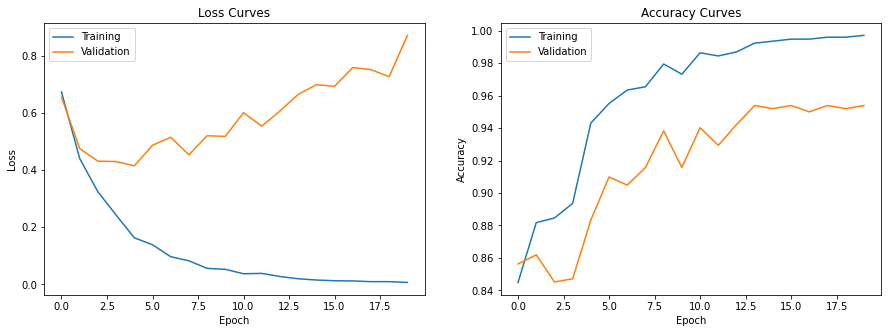

In [39]:
model = models.vgg19(pretrained=True)
model.classifier[6] = nn.Linear(in_features=4096, out_features=3, bias=True)
print(model)

loss_func = nn.CrossEntropyLoss(weight=torch.tensor([98/2551, 98/608, 98/98]).to(device=device))
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-2)
train_losses, train_accs, val_losses, val_accs, best = train(model, optimizer, loss_func, epochs=20)

#Plot
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(train_losses, label='Training')
axs[0].plot(val_losses, label='Validation')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_title('Loss Curves')
axs[0].legend()

axs[1].plot(train_accs, label='Training')
axs[1].plot(val_accs, label='Validation')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_title('Accuracy Curves')
axs[1].legend()

plt.show()

In [40]:
test(best['model'], loss_func)

Mask Accuracy: 328/353 -> 0.92918
No Mask Accuracy: 40/42 -> 0.95238
Incorrect Mask Accuracy: 8/13 -> 0.61538


(0.4594617113471031,
 0.9205729166666666,
 0.9291784702549575,
 0.9523809523809523,
 0.6153846153846154)

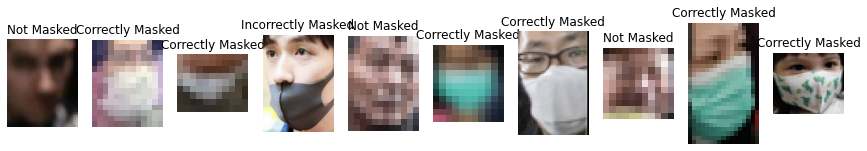

In [41]:
test_predict(best['model'])

In [42]:
torch.save(best['model'].state_dict(), './saved_models/vgg19.pt')

### Not Pre-Trained VGG-19

Epoch 0, train loss = 1.092005, train acc = 0.784118,                 val loss = 1.079262, val acc = 0.836787
Epoch 1, train loss = 1.077007, train acc = 0.784866,                 val loss = 1.038793, val acc = 0.836787
Epoch 2, train loss = 1.030976, train acc = 0.785241,                 val loss = 0.967121, val acc = 0.836787
Epoch 3, train loss = 0.941007, train acc = 0.695782,                 val loss = 0.885857, val acc = 0.726902
Epoch 4, train loss = 0.818836, train acc = 0.658907,                 val loss = 0.794094, val acc = 0.639351
Epoch 5, train loss = 0.658494, train acc = 0.854731,                 val loss = 0.688458, val acc = 0.833475
Epoch 6, train loss = 0.697024, train acc = 0.886650,                 val loss = 0.657287, val acc = 0.874490
Epoch 7, train loss = 0.518631, train acc = 0.863745,                 val loss = 0.598570, val acc = 0.818699
Epoch 8, train loss = 0.570332, train acc = 0.878390,                 val loss = 0.596763, val acc = 0.842137
Epoch 9, t

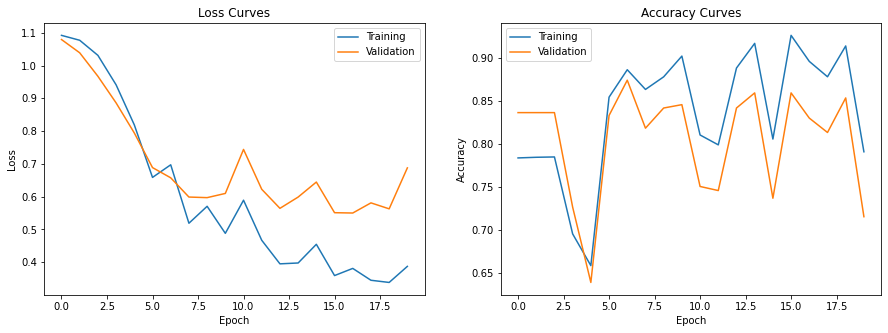

In [43]:
model = models.vgg19(pretrained=False)
model.classifier[6] = nn.Linear(in_features=4096, out_features=3, bias=True)

loss_func = nn.CrossEntropyLoss(weight=torch.tensor([98/2551, 98/608, 98/98]).to(device=device))
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-2)
train_losses, train_accs, val_losses, val_accs, best = train(model, optimizer, loss_func, epochs=20)

#Plot
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(train_losses, label='Training')
axs[0].plot(val_losses, label='Validation')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_title('Loss Curves')
axs[0].legend()

axs[1].plot(train_accs, label='Training')
axs[1].plot(val_accs, label='Validation')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_title('Accuracy Curves')
axs[1].legend()

plt.show()

In [44]:
test(best['model'], loss_func)

Mask Accuracy: 320/353 -> 0.90652
No Mask Accuracy: 34/42 -> 0.80952
Incorrect Mask Accuracy: 10/13 -> 0.76923


(0.4267639070749283,
 0.8971354166666666,
 0.9065155807365439,
 0.8095238095238095,
 0.7692307692307693)

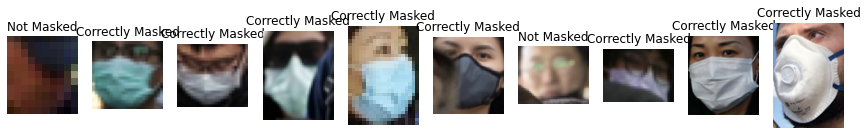

In [45]:
test_predict(best['model'])

### Pre-Trained VGG-19 with BatchNorm

In [ ]:
model = models.vgg19_bn(pretrained=True)
model.classifier[6] = nn.Linear(in_features=4096, out_features=3, bias=True)
print(model)

loss_func = nn.CrossEntropyLoss(weight=torch.tensor([98/2551, 98/608, 98/98]).to(device=device))
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-2)
train_losses, train_accs, val_losses, val_accs, best = train(model, optimizer, loss_func, epochs=20)

#Plot
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(train_losses, label='Training')
axs[0].plot(val_losses, label='Validation')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_title('Loss Curves')
axs[0].legend()

axs[1].plot(train_accs, label='Training')
axs[1].plot(val_accs, label='Validation')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_title('Accuracy Curves')
axs[1].legend()

plt.show()

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /tmp/xdg-cache/torch/checkpoints/vgg19_bn-c79401a0.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 25

Epoch 0, train loss = 0.892985, train acc = 0.714564,                 val loss = 0.934434, val acc = 0.727751
Epoch 1, train loss = 0.739158, train acc = 0.815594,                 val loss = 0.839380, val acc = 0.805282
Epoch 2, train loss = 0.594264, train acc = 0.840608,                 val loss = 0.775622, val acc = 0.815048
Epoch 3, train loss = 0.410248, train acc = 0.894695,                 val loss = 0.699231, val acc = 0.852412
Epoch 4, train loss = 0.272454, train acc = 0.928718,                 val loss = 0.694796, val acc = 0.888672
Epoch 5, train loss = 0.177661, train acc = 0.952229,                 val loss = 0.693726, val acc = 0.900391
Epoch 6, train loss = 0.123144, train acc = 0.964622,                 val loss = 0.731267, val acc = 0.916016
Epoch 7, train loss = 0.074971, train acc = 0.983099,                 val loss = 0.751450, val acc = 0.919922
Epoch 8, train loss = 0.051358, train acc = 0.987907,                 val loss = 0.884159, val acc = 0.931641
Epoch 9, t

In [46]:
test(best['model'], loss_func)

Mask Accuracy: 321/353 -> 0.90935
No Mask Accuracy: 36/42 -> 0.85714
Incorrect Mask Accuracy: 4/13 -> 0.30769


(0.8170913383364677,
 0.8912760416666666,
 0.9093484419263456,
 0.8571428571428571,
 0.3076923076923077)

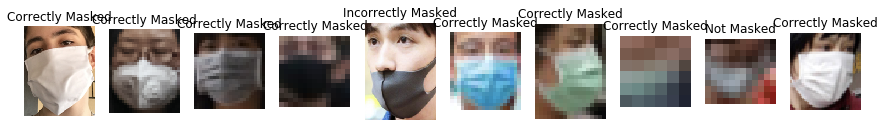

In [47]:
test_predict(best['model'])

In [48]:
torch.save(best['model'].state_dict(), './saved_models/vgg19_bn.pt')

### Pre-Trained VGG-16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Epoch 0, train loss = 0.671492, train acc = 0.823786,                 val loss = 0.731924, val acc = 0.792204
Epoch 1, train loss = 0.463600, train acc = 0.861036,                 val loss = 0.589317, val acc = 0.832371
Epoch 2, train loss = 0.340594, train acc = 0.911284,                 val loss = 0.493244, val acc = 0.884511
Epoch 3, train loss = 0.262783, train acc = 0.925265,                 val loss = 0.456753, val acc = 0.894276
Epoch 4, train loss = 0.203021, train acc = 0.942687,                 val loss = 0.458124, val acc = 0.900136
Epoch 5, train loss = 0.157680, train acc = 0.954106,                 val loss = 0.472070, val acc = 0.918818
Epoch 6, train loss = 0.126616, train acc = 0.962519,                 val loss = 0.462130, val acc = 0.924677
Epoch 7, train loss = 0.100552, train acc = 0.965070,                 val loss = 0.503179, val acc = 0.928584
Epoch 8, train loss = 0.073632, train acc = 0.972656,                 val loss = 0.519237, val acc = 0.936396
Epoch 9, t

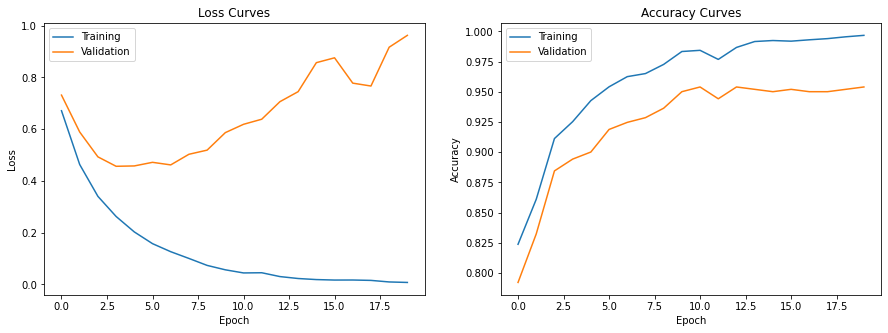

In [47]:
model = models.vgg16(pretrained=True)
model.classifier[6] = nn.Linear(in_features=4096, out_features=3, bias=True)
print(model)

loss_func = nn.CrossEntropyLoss(weight=torch.tensor([98/2551, 98/608, 98/98]).to(device=device))
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-2)
train_losses, train_accs, val_losses, val_accs, best = train(model, optimizer, loss_func, epochs=20)

#Plot
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(train_losses, label='Training')
axs[0].plot(val_losses, label='Validation')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_title('Loss Curves')
axs[0].legend()

axs[1].plot(train_accs, label='Training')
axs[1].plot(val_accs, label='Validation')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_title('Accuracy Curves')
axs[1].legend()

plt.show()

In [48]:
test(best['model'], loss_func)

Mask Accuracy: 330/353 -> 0.93484
No Mask Accuracy: 37/42 -> 0.88095
Incorrect Mask Accuracy: 9/13 -> 0.69231


(0.44886406511068344,
 0.912109375,
 0.9348441926345609,
 0.8809523809523809,
 0.6923076923076923)

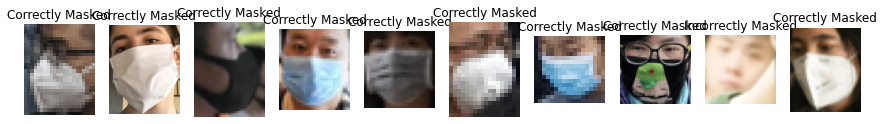

In [49]:
test_predict(best['model'])

In [50]:
torch.save(best['model'].state_dict(), './saved_models/vgg16.pt')

### Not Pre-Trained VGG-16

Epoch 0, train loss = 1.089879, train acc = 0.784118,                 val loss = 1.067875, val acc = 0.836787
Epoch 1, train loss = 1.070551, train acc = 0.782621,                 val loss = 1.031652, val acc = 0.836787
Epoch 2, train loss = 1.017669, train acc = 0.800945,                 val loss = 0.953847, val acc = 0.860224
Epoch 3, train loss = 0.876852, train acc = 0.794192,                 val loss = 0.857791, val acc = 0.769616
Epoch 4, train loss = 0.679518, train acc = 0.767370,                 val loss = 0.693887, val acc = 0.711617
Epoch 5, train loss = 0.642359, train acc = 0.766247,                 val loss = 0.696355, val acc = 0.709664
Epoch 6, train loss = 0.671566, train acc = 0.546306,                 val loss = 0.759295, val acc = 0.528618
Epoch 7, train loss = 0.518649, train acc = 0.790059,                 val loss = 0.597945, val acc = 0.760105
Epoch 8, train loss = 0.470043, train acc = 0.857809,                 val loss = 0.564853, val acc = 0.808933
Epoch 9, t

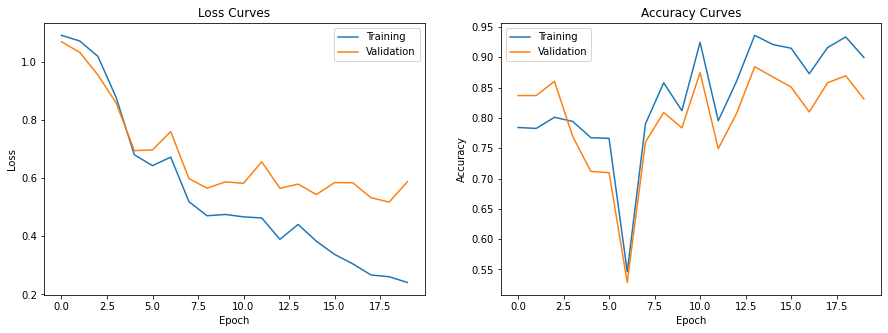

In [55]:
model = models.vgg16(pretrained=False)
model.classifier[6] = nn.Linear(in_features=4096, out_features=3, bias=True)

loss_func = nn.CrossEntropyLoss(weight=torch.tensor([98/2551, 98/608, 98/98]).to(device=device))
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-2)
train_losses, train_accs, val_losses, val_accs, best = train(model, optimizer, loss_func, epochs=20)

#Plot
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(train_losses, label='Training')
axs[0].plot(val_losses, label='Validation')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_title('Loss Curves')
axs[0].legend()

axs[1].plot(train_accs, label='Training')
axs[1].plot(val_accs, label='Validation')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_title('Accuracy Curves')
axs[1].legend()

plt.show()

In [56]:
test(best['model'], loss_func)

Mask Accuracy: 332/353 -> 0.94051
No Mask Accuracy: 36/42 -> 0.85714
Incorrect Mask Accuracy: 8/13 -> 0.61538


(0.4712103456258774,
 0.9205729166666666,
 0.9405099150141643,
 0.8571428571428571,
 0.6153846153846154)

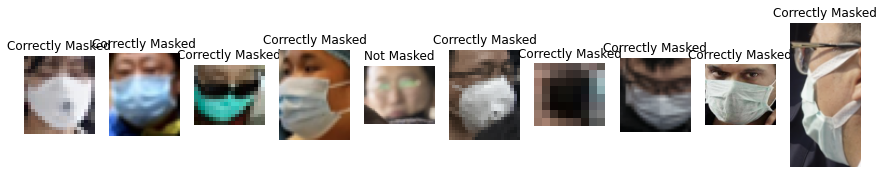

In [57]:
test_predict(best['model'])

In [58]:
torch.save(best['model'].state_dict(), './saved_models/vgg16_notpretrained.pt')

In [48]:
test(best['model'], loss_func)

Mask Accuracy: 330/353 -> 0.93484
No Mask Accuracy: 37/42 -> 0.88095
Incorrect Mask Accuracy: 9/13 -> 0.69231


(0.44886406511068344,
 0.912109375,
 0.9348441926345609,
 0.8809523809523809,
 0.6923076923076923)

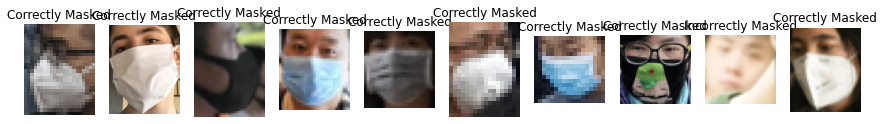

In [49]:
test_predict(best['model'])

In [50]:
torch.save(best['model'].state_dict(), './saved_models/vgg16.pt')

### Pre-Trained VGG-16 with BatchNorm

Epoch 0, train loss = 0.987285, train acc = 0.684664,                 val loss = 1.023745, val acc = 0.655231
Epoch 1, train loss = 0.870960, train acc = 0.766395,                 val loss = 0.964619, val acc = 0.699049
Epoch 2, train loss = 0.737712, train acc = 0.806654,                 val loss = 0.906745, val acc = 0.734460
Epoch 3, train loss = 0.509301, train acc = 0.869075,                 val loss = 0.786461, val acc = 0.795262
Epoch 4, train loss = 0.314945, train acc = 0.908812,                 val loss = 0.704876, val acc = 0.852157
Epoch 5, train loss = 0.179265, train acc = 0.938180,                 val loss = 0.670602, val acc = 0.876698
Epoch 6, train loss = 0.115187, train acc = 0.963268,                 val loss = 0.683782, val acc = 0.901240
Epoch 7, train loss = 0.074027, train acc = 0.971454,                 val loss = 0.708918, val acc = 0.894276
Epoch 8, train loss = 0.044342, train acc = 0.982425,                 val loss = 0.830710, val acc = 0.912959
Epoch 9, t

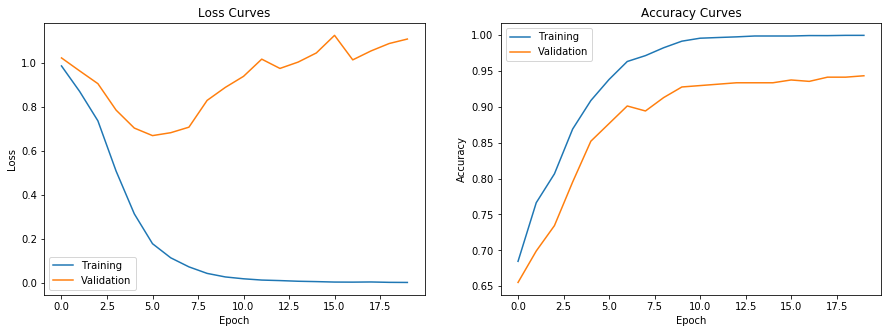

In [50]:
model = models.vgg16_bn(pretrained=True)
model.classifier[6] = nn.Linear(in_features=4096, out_features=3, bias=True)

loss_func = nn.CrossEntropyLoss(weight=torch.tensor([98/2551, 98/608, 98/98]).to(device=device))
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-2)
train_losses, train_accs, val_losses, val_accs, best = train(model, optimizer, loss_func, epochs=20)

#Plot
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(train_losses, label='Training')
axs[0].plot(val_losses, label='Validation')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_title('Loss Curves')
axs[0].legend()

axs[1].plot(train_accs, label='Training')
axs[1].plot(val_accs, label='Validation')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_title('Accuracy Curves')
axs[1].legend()

plt.show()

In [51]:
test(best['model'], loss_func)

Mask Accuracy: 321/353 -> 0.90935
No Mask Accuracy: 30/42 -> 0.71429
Incorrect Mask Accuracy: 3/13 -> 0.23077


(1.1650786995887756,
 0.8606770833333334,
 0.9093484419263456,
 0.7142857142857143,
 0.23076923076923078)

In [ ]:
test_predict(best['model'])

In [ ]:
torch.save(best['model'].state_dict(), './saved_models/vgg16_bn.pt')

### Testing on Images

In [15]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn()
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes+1)

    return model
    
rcnn_model = get_model_instance_segmentation(3)
rcnn_model.load_state_dict(torch.load('./saved_models/rcnn_model.pt'))
rcnn_model.eval()
rcnn_model = rcnn_model.to(device=device)

In [21]:
def pip_face_recognition(img_path):
    fr_image = face_recognition.load_image_file(img_path)
    face_locations = face_recognition.face_locations(fr_image)
    return face_locations

def faster_rcnn(img_path):
    img = Image.open(img_path).convert("RGB")
    img_tensor = T.functional.to_tensor(img)
    img_tensor = img_tensor.to(device=device)
    pred = rcnn_model(torch.unsqueeze(img_tensor, 0))
    
    rearranged = []
    for l in pred[0]['boxes'].cpu().detach().numpy():
        rearranged.append([l[1], l[2], l[3], l[0]])
    return rearranged
    
def face_detection_and_prediction(model, face_detector, num_images=30):
    fig, axs = plt.subplots(num_images, 1, figsize=(10, num_images*5))
    
    predict_dict = {0: 'tab:green', 1: 'tab:red', 2: 'tab:orange'}
    
    model = model.to(device='cpu') 
    model.eval() 
    with torch.no_grad():
        for count, img_name in tqdm(enumerate(sorted(os.listdir('./input/Face_Mask_Dataset/images'), reverse=True))):
            if count == num_images:
                break
            img_path = os.path.join('./input/Face_Mask_Dataset/images', img_name)
            face_locations = face_detector(img_path)
            
            pil_img = Image.open(img_path).convert('RGB')
            axs[count].imshow(pil_img)
            axs[count].axis('off')
            
            for top, right, bottom, left in face_locations:
                cropped_img = pil_img.crop((left, top, right, bottom))
                # Normalize stats from ImageNet
                compose = T.Compose([
                    T.Resize((35, 35)),
                    T.ToTensor(),
                    T.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
                ])
                
                scores = model(torch.unsqueeze(compose(cropped_img), 0))
                preds = torch.argmax(scores, axis=1)
                
                rect = patches.Rectangle((left, top), right-left, bottom-top, linewidth=3, 
                                         edgecolor= predict_dict[preds[0].item()], facecolor='none')
                axs[count].add_patch(rect)
            
    plt.show()

30it [00:46,  1.06it/s]

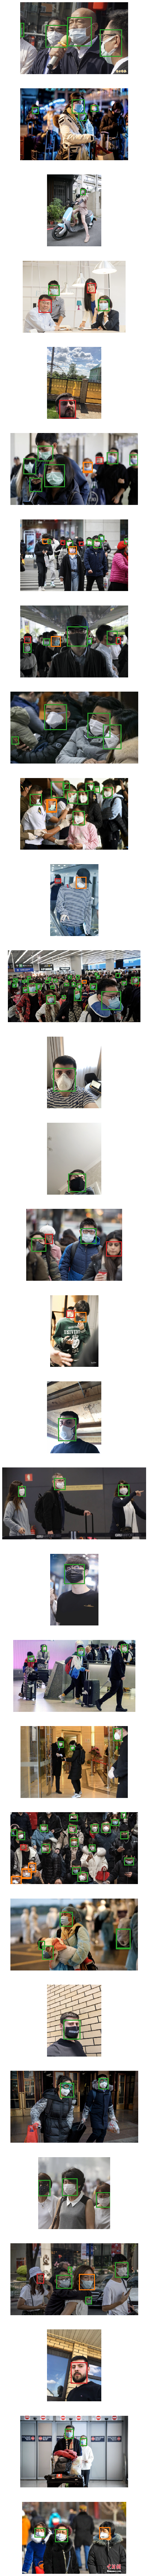

In [26]:
model = models.vgg19(pretrained=True)
model.classifier[6] = nn.Linear(in_features=4096, out_features=3, bias=True)
model.load_state_dict(torch.load('./saved_models/vgg19.pt'))
model.eval()

face_detection_and_prediction(model, face_detector=faster_rcnn)